# English Accent Detection: A Comparison of Audio, Spectrogram and Text Classification Method using Transformers
##### Group 11
##### Candidate Numbers:  31948, 24692, 24155
##### Date: 29 April 2024

Data Source: https://huggingface.co/datasets/WillHeld/accented_common_voice/tree/refs%2Fconvert%2Fparquet/default/partial-train

# Audio Array Classification

In [35]:
%%capture
! pip install datasets evaluate
! pip install accelerate
! pip install wandb

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os

from datasets import Dataset, Audio, load_dataset
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq
from transformers import Wav2Vec2Processor
import random
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, AutoFeatureExtractor
import evaluate
from datasets import Dataset, Audio
import torch
from transformers import EarlyStoppingCallback, IntervalStrategy
from datasets import load_from_disk
import wandb
wandb.login()
wandb.init(project="accents_classification")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to data location
os.chdir("/content/drive/My Drive/ST311")

In [ ]:
# Load data
df0 = pq.read_table(source= '0000.parquet').to_pandas()
df1 = pq.read_table(source= '0001.parquet').to_pandas()
df2 = pq.read_table(source= '0002.parquet').to_pandas()
df3 = pq.read_table(source= '0003.parquet').to_pandas()
df4 = pq.read_table(source= '0004.parquet').to_pandas()
df5 = pq.read_table(source= '0005.parquet').to_pandas()
df6 = pq.read_table(source= '0006.parquet').to_pandas()
df7 = pq.read_table(source= '0007.parquet').to_pandas()
data = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7])
data.reset_index(drop=True, inplace=True)

In [ ]:
data = data.drop(['path'], axis=1)
data = data.drop(['up_votes'], axis=1)
data = data.drop(['down_votes'], axis=1)
data = data.drop(['age'], axis=1)
data = data.drop(['gender'], axis=1)

#train test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
data.value_counts()

In [14]:
print(len(data), len(train_data), len(test_data))

7678 6142 1536


In [ ]:
test_data.iloc[1529]

accents                                 United States English
sentence                              They are on the ground.
audio       {'array': [2.2737367544323206e-12, 9.094947017...
Name: 7482, dtype: object

In [ ]:
test_data['accents'].value_counts()

accents
United States English                                670
India and South Asia (India, Pakistan, Sri Lanka)    225
England English                                      203
Filipino                                             136
Australian English                                   135
Canadian English                                     100
Irish English                                         39
Scottish English                                      28
Name: count, dtype: int64

In [ ]:
train_data['accents'].value_counts()

accents
United States English                                2577
India and South Asia (India, Pakistan, Sri Lanka)     963
England English                                       891
Australian English                                    528
Filipino                                              471
Canadian English                                      395
Irish English                                         226
Scottish English                                       91
Name: count, dtype: int64

In [ ]:
test_data.iloc[0,2]

{'array': array([ 0.00000000e+00,  2.18278728e-11,  1.45519152e-11, ...,
        -4.17522733e-06, -4.00739464e-06,  1.34157199e-06]),
 'path': './accents/datasets/common_voice_16_1/en/clips/common_voice_en_20275899.mp3',
 'sampling_rate': 16000}

In [ ]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(data['accents']), y = train_data['accents'])
print(weights)

[1.45407197 1.94367089 0.86167228 1.63004246 0.79724818 3.39712389
 8.43681319 0.29792394]


In [ ]:
train_ds = Dataset.from_pandas(train_data)
test_ds = Dataset.from_pandas(test_data)

In [ ]:
train_ds = train_ds.class_encode_column("accents")
test_ds = test_ds.class_encode_column("accents")

Casting to class labels:   0%|          | 0/6142 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1536 [00:00<?, ? examples/s]

20% 80% split\
accents column类型转换了

## Audio Classification without Spectrogram

In [ ]:
train_ds = train_ds.remove_columns("sentence")
test_ds = test_ds.remove_columns("sentence")

In [ ]:
# labels = accents_ds["train"].features["accents"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = str(i)
#     id2label[str(i)] = label

In [ ]:
label2id = {'Australian English': '0',
 'Canadian English': '1',
 'England English': '2',
 'Filipino': '3',
 'India and South Asia (India, Pakistan, Sri Lanka)': '4',
 'Irish English': '5',
 'Scottish English': '6',
 'United States English': '7'}
id2label = {'0': 'Australian English',
 '1': 'Canadian English',
 '2': 'England English',
 '3': 'Filipino',
 '4': 'India and South Asia (India, Pakistan, Sri Lanka)',
 '5': 'Irish English',
 '6': 'Scottish English',
 '7': 'United States English'}

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [11]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
def transform_audio(example):
    array = np.array(example['audio']['array'], dtype=np.float32)
    sampling_rate = example['audio']['sampling_rate']  # Already set correctly, just referencing it
    return {'audio': {'array': array, 'sampling_rate': sampling_rate}}

In [ ]:
train_ds = train_ds.map(transform_audio)
test_ds = test_ds.map(transform_audio)

Map:   0%|          | 0/6142 [00:00<?, ? examples/s]

Map:   0%|          | 0/1536 [00:00<?, ? examples/s]

In [ ]:
train_ds = train_ds.cast_column("audio", Audio(sampling_rate=16_000))
test_ds = test_ds.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=160000, truncation=True
    )

    return inputs

# Apply preprocessing
train_ds = train_ds.map(preprocess_function, remove_columns=["audio"], batched=True)
test_ds = test_ds.map(preprocess_function, remove_columns=["audio"], batched=True)

# Rename 'accents' column to 'label'
train_ds = train_ds.rename_column("accents", "label")
test_ds = test_ds.rename_column("accents", "label")


In [ ]:
train_ds.save_to_disk("train_23")
test_ds.save_to_disk("test_23")

Saving the dataset (0/5 shards):   0%|          | 0/6142 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1536 [00:00<?, ? examples/s]

In [ ]:
train_ds = load_from_disk("train_23")
test_ds = load_from_disk("test_23")

In [ ]:
# accuracy = evaluate.load("accuracy")
# f1 = evaluate.load("f1")
# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return {
#         'accuracy': accuracy.compute(predictions=predictions, references=eval_pred.label_ids),
#         'f1': f1.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
#     }

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
mcc = evaluate.load("matthews_correlation")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids
    return {
        'accuracy': accuracy.compute(predictions=predictions, references=references)['accuracy'],
        'f1_weighted': f1.compute(predictions=predictions, references=references, average='weighted')['f1'],
        'precision_weighted': precision.compute(predictions=predictions, references=references, average='weighted')['precision'],
        'recall_weighted': recall.compute(predictions=predictions, references=references, average='weighted')['recall'],
        'mcc': mcc.compute(predictions=predictions, references=references)['matthews_correlation']
    }

In [ ]:
num_labels = 8
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ordered_weights = [1.4475867269984917,
 1.9388888888888889,
 0.8772851919561243,
 1.581136738056013,
 0.8078703703703703,
 3.621698113207547,
 8.065126050420169,
 0.2955805358792732]

In [ ]:
classes = list(id2label.values())
class_weights = dict(zip(classes, weights))
print(class_weights)
ordered_weights = [class_weights[x] for x in id2label.values()]

In [ ]:
wandb.init(project="accents_classification_28", name = "run_2")

eval/accuracy,▁▁█
eval/f1_weighted,▁▁█
eval/loss,███▁
eval/mcc,▁▁█
eval/precision_weighted,▁▂█
eval/recall_weighted,▁▁█
eval/runtime,█▅▂▁
eval/samples_per_second,▁▄▇█
eval/steps_per_second,▁▄▇█
train/epoch,▁▁▂▃▄▆▆▇█
train/global_step,▁▁▂▁▂▃▄▅▆▆▇█


In [ ]:
training_args = TrainingArguments(
    output_dir="wav2vec-23",
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps = 50,
    save_strategy=IntervalStrategy.STEPS,
    save_steps = 100,
    save_total_limit = 4,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="wandb"
)

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weights, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.081277847290039,
 'eval_accuracy': 0.095703125,
 'eval_f1_weighted': 0.11839429320686339,
 'eval_precision_weighted': 0.27227572133292505,
 'eval_recall_weighted': 0.095703125,
 'eval_mcc': -0.0022599274251548247,
 'eval_runtime': 73.9545,
 'eval_samples_per_second': 20.77,
 'eval_steps_per_second': 0.649}

In [ ]:
trained = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Mcc
50,1.837200,1.764204,0.757812,0.746339,0.794171,0.757812,0.676719
100,1.001900,0.891448,0.973307,0.973553,0.975202,0.973307,0.965212
150,0.555400,0.492019,0.995443,0.995428,0.995512,0.995443,0.993934
200,0.342900,0.296086,0.994792,0.994799,0.994855,0.994792,0.993071
250,0.236300,0.204503,0.998047,0.998049,0.998065,0.998047,0.997397
300,0.181300,0.164038,0.997396,0.997394,0.997412,0.997396,0.996528
350,0.147500,0.132456,0.998698,0.998701,0.998714,0.998698,0.998265
400,0.132700,0.117824,0.998698,0.998701,0.998714,0.998698,0.998265
450,0.123200,0.112002,0.998047,0.998050,0.998062,0.998047,0.997397


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Mcc
50,1.837200,1.764204,0.757812,0.746339,0.794171,0.757812,0.676719
100,1.001900,0.891448,0.973307,0.973553,0.975202,0.973307,0.965212
150,0.555400,0.492019,0.995443,0.995428,0.995512,0.995443,0.993934
200,0.342900,0.296086,0.994792,0.994799,0.994855,0.994792,0.993071
250,0.236300,0.204503,0.998047,0.998049,0.998065,0.998047,0.997397
300,0.181300,0.164038,0.997396,0.997394,0.997412,0.997396,0.996528
350,0.147500,0.132456,0.998698,0.998701,0.998714,0.998698,0.998265
400,0.132700,0.117824,0.998698,0.998701,0.998714,0.998698,0.998265
450,0.123200,0.112002,0.998047,0.998050,0.998062,0.998047,0.997397


In [ ]:
trainer.evaluate()

{'eval_loss': 0.11782387644052505,
 'eval_accuracy': 0.9986979166666666,
 'eval_f1_weighted': 0.9987012334284002,
 'eval_precision_weighted': 0.9987141927083334,
 'eval_recall_weighted': 0.9986979166666666,
 'eval_mcc': 0.9982646808828041,
 'eval_runtime': 72.4762,
 'eval_samples_per_second': 21.193,
 'eval_steps_per_second': 0.662,
 'epoch': 10.0}

In [ ]:
trained

TrainOutput(global_step=240, training_loss=0.7800431281328202, metrics={'train_runtime': 3625.1638, 'train_samples_per_second': 8.471, 'train_steps_per_second': 0.066, 'total_flos': 2.400507469299843e+18, 'train_loss': 0.7800431281328202, 'epoch': 5.0})

In [ ]:
trainer.save_model("audio_27apr")

In [ ]:
trainer.evaluate()

In [4]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_ds['label']
y_true_names = [id2label[str(id)] for id in y_true]
y_pred_names = [id2label[str(id)] for id in y_pred]
cm2 = confusion_matrix(y_true_names, y_pred_names, labels = list(id2label.values()))

In [ ]:
cm2

array([[135,   0,   0,   0,   0,   0,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0,   0],
       [  0,   0, 202,   0,   0,   0,   0,   1],
       [  0,   0,   0, 136,   0,   0,   0,   0],
       [  0,   0,   0,   0, 225,   0,   0,   0],
       [  0,   0,   0,   0,   0,  39,   0,   0],
       [  0,   0,   0,   0,   0,   0,  28,   0],
       [  0,   0,   0,   0,   0,   1,   0, 669]])

In [6]:
cm = np.array([[135,   0,   0,   0,   0,   0,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0,   0],
       [  0,   0, 202,   0,   0,   0,   0,   1],
       [  0,   0,   0, 136,   0,   0,   0,   0],
       [  0,   0,   0,   0, 225,   0,   0,   0],
       [  0,   0,   0,   0,   0,  39,   0,   0],
       [  0,   0,   0,   0,   0,   0,  28,   0],
       [  0,   0,   0,   0,   0,   1,   0, 669]])

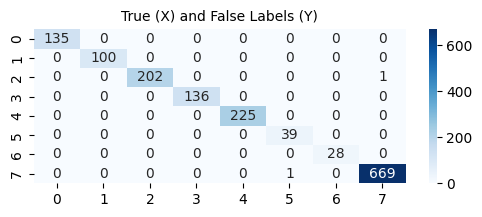

In [34]:
plt.figure(figsize=(6, 2))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('True (X) and False Labels (Y)', fontsize = 10)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Saving the figure with a high DPI
plt.savefig('cm_audio.png', dpi=1000)

In [ ]:
np.flatnonzero(y_true != y_pred)

array([ 469, 1529])

In [ ]:
id2label.values()

dict_values(['Australian English', 'Canadian English', 'England English', 'Filipino', 'India and South Asia (India, Pakistan, Sri Lanka)', 'Irish English', 'Scottish English', 'United States English'])

In [ ]:
id2label.values()

dict_values(['Australian English', 'Canadian English', 'England English', 'Filipino', 'India and South Asia (India, Pakistan, Sri Lanka)', 'Irish English', 'Scottish English', 'United States English'])

In [ ]:
y_true[469]

2

In [ ]:
y_pred[469]

7

In [ ]:
y_true[1529]

7

In [ ]:
y_pred[1529]

5

In [ ]:
# pred = irish
test_data.iloc[[1529]]

,accents,sentence,audio
7482,United States English,They are on the ground.,"{'array': [2.2737367544323206e-12, 9.094947017..."


In [ ]:
# pred = US
test_data.iloc[[469]]

,accents,sentence,audio
965,England English,As you wish.,"{'array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

# Spectrogram Classification


In [ ]:
# !pip install librosa
# !pip install --upgrade transformers
# !pip install accelerate -U

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import time
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from PIL import Image
import IPython.display as ipd
import numpy as np
import librosa


cuda = torch.cuda.is_available()
import pyarrow.parquet as pq

df0 = pq.read_table(source= '0000.parquet').to_pandas()
df1 = pq.read_table(source= '0001.parquet').to_pandas()
df2 = pq.read_table(source= '0002.parquet').to_pandas()
df3 = pq.read_table(source= '0003.parquet').to_pandas()
df4 = pq.read_table(source= '0004.parquet').to_pandas()
df5 = pq.read_table(source= '0005.parquet').to_pandas()
df6 = pq.read_table(source= '0006.parquet').to_pandas()
df7 = pq.read_table(source= '0007.parquet').to_pandas()

## **Method 2: Add noise, change pitch and change speed**

In [ ]:
data = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7])
data.reset_index(drop=True, inplace=True)
data = data.drop(['path'], axis=1)
data = data.drop(['up_votes'], axis=1)
data = data.drop(['down_votes'], axis=1)
data = data.drop(['age'], axis=1)
data = data.drop(['gender'], axis=1)
#train test split
from sklearn.model_selection import train_test_split
data, test_data = train_test_split(data, test_size=0.2, random_state=42)
data['accents'].value_counts()


United States English                                2577
India and South Asia (India, Pakistan, Sri Lanka)     963
England English                                       891
Australian English                                    528
Filipino                                              471
Canadian English                                      395
Irish English                                         226
Scottish English                                       91
Name: accents, dtype: int64

In [ ]:
test_data['accents'].value_counts()

United States English                                670
India and South Asia (India, Pakistan, Sri Lanka)    225
England English                                      203
Filipino                                             136
Australian English                                   135
Canadian English                                     100
Irish English                                         39
Scottish English                                      28
Name: accents, dtype: int64

In [ ]:
new_audio = []
for r in data['audio']:
    new_audio.append(r['array'])
data['audio'] = new_audio
us = data[data['accents'] == 'United States English']
us = us[:800]

indian = data[data['accents'] == 'India and South Asia (India, Pakistan, Sri Lanka)']
indian = indian[:800]

england = data[data['accents'] == 'England English']
england = england[:800]

filipino = data[data['accents'] == 'Filipino']
filipino.reset_index(drop=True, inplace=True)

australian = data[data['accents'] == 'Australian English']
australian.reset_index(drop=True, inplace=True)

scottish = data[data['accents'] == 'Scottish English']
scottish.reset_index(drop=True, inplace=True)

irish = data[data['accents'] == 'Irish English']
irish.reset_index(drop=True, inplace=True)

canadian = data[data['accents'] == 'Canadian English']
canadian.reset_index(drop=True, inplace=True)
scottish_arrays = scottish['audio']
irish_arrays = irish['audio']
canadian_arrays = canadian['audio']
australian_arrays = australian['audio']
filipino_arrays = filipino['audio']

In [ ]:
sampling_rate = 16000  # This is the sampling rate from your data

# Function to add noise
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_level * noise
    return augmented_audio

# Function to change pitch
def change_pitch(audio, sampling_rate, n_steps=5):
    return librosa.effects.pitch_shift(audio, sr=sampling_rate, n_steps=n_steps)

# Function to change speed
def change_speed(audio, speed_factor=1.5):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

In [ ]:
scottish_augmented = []
irish_augmented = []
canadian_augmented = []
australian_augmented = []
filipino_augmented = []

for i in range(len(scottish_arrays)):
    audio = scottish_arrays[i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    scottish_augmented.append(noisy_audio)
    scottish_augmented.append(pitched_audio)
    scottish_augmented.append(speeded_audio)

for i in range(190):
    audio = irish_arrays[i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    irish_augmented.append(noisy_audio)
    irish_augmented.append(pitched_audio)
    irish_augmented.append(speeded_audio)

for i in range(130):
    audio = canadian_arrays[i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    canadian_augmented.append(noisy_audio)
    canadian_augmented.append(pitched_audio)
    canadian_augmented.append(speeded_audio)

for i in range(75):
    audio = australian_arrays[i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    australian_augmented.append(noisy_audio)
    australian_augmented.append(pitched_audio)
    australian_augmented.append(speeded_audio)

for i in range(80):
    audio = filipino_arrays[i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    filipino_augmented.append(noisy_audio)
    filipino_augmented.append(pitched_audio)
    filipino_augmented.append(speeded_audio)

In [ ]:
scottish_augmented_sentence = []
irish_augmented_sentence = []
canadian_augmented_sentence = []
australian_augmented_sentence = []
filipino_augmented_sentence = []

for i in range(len(scottish)):
    scottish_augmented_sentence.append(scottish['sentence'][i])
    scottish_augmented_sentence.append(scottish['sentence'][i])
    scottish_augmented_sentence.append(scottish['sentence'][i])

for i in range(190):
    irish_augmented_sentence.append(irish['sentence'][i])
    irish_augmented_sentence.append(irish['sentence'][i])
    irish_augmented_sentence.append(irish['sentence'][i])

for i in range(130):
    canadian_augmented_sentence.append(canadian['sentence'][i])
    canadian_augmented_sentence.append(canadian['sentence'][i])
    canadian_augmented_sentence.append(canadian['sentence'][i])

for i in range(75):
    australian_augmented_sentence.append(australian['sentence'][i])
    australian_augmented_sentence.append(australian['sentence'][i])
    australian_augmented_sentence.append(australian['sentence'][i])

for i in range(80):
    filipino_augmented_sentence.append(filipino['sentence'][i])
    filipino_augmented_sentence.append(filipino['sentence'][i])
    filipino_augmented_sentence.append(filipino['sentence'][i])


In [ ]:
scottish_augmented_df = pd.DataFrame({'accents': 'Scottish English', 'sentence': scottish_augmented_sentence, 'audio': scottish_augmented})
irish_augmented_df = pd.DataFrame({'accents': 'Irish English', 'sentence': irish_augmented_sentence, 'audio': irish_augmented})
canadian_augmented_df = pd.DataFrame({'accents': 'Canadian English', 'sentence': canadian_augmented_sentence, 'audio': canadian_augmented})
australian_augmented_df = pd.DataFrame({'accents': 'Australian English', 'sentence': australian_augmented_sentence, 'audio': australian_augmented})
filipino_augmented_df = pd.DataFrame({'accents': 'Filipino', 'sentence': filipino_augmented_sentence, 'audio': filipino_augmented})

scottish = pd.concat([scottish, scottish_augmented_df])
scottish.reset_index(drop=True, inplace=True)
irish = pd.concat([irish, irish_augmented_df])
irish.reset_index(drop=True, inplace=True)
canadian = pd.concat([canadian, canadian_augmented_df])
canadian.reset_index(drop=True, inplace=True)
australian = pd.concat([australian, australian_augmented_df])
australian.reset_index(drop=True, inplace=True)
filipino = pd.concat([filipino, filipino_augmented_df])
filipino.reset_index(drop=True, inplace=True)

In [ ]:
data_augmented = pd.concat([us,indian,england,scottish,irish,canadian,australian,filipino])

In [ ]:
#second round augmentation for scottish
scottish_augmented = []
for i in range(120, 240):
    audio = scottish['audio'][i]
    noisy_audio = add_noise(audio)
    pitched_audio = change_pitch(audio, sampling_rate)
    speeded_audio = change_speed(audio)
    scottish_augmented.append(noisy_audio)
    scottish_augmented.append(pitched_audio)
    scottish_augmented.append(speeded_audio)

scottish_augmented_sentence = []
for i in range(120, 240):
    scottish_augmented_sentence.append(scottish['sentence'][i])
    scottish_augmented_sentence.append(scottish['sentence'][i])
    scottish_augmented_sentence.append(scottish['sentence'][i])

scottish_augmented_df = pd.DataFrame({'accents': 'Scottish English', 'sentence': scottish_augmented_sentence, 'audio': scottish_augmented})
data_augmented = pd.concat([data_augmented, scottish_augmented_df])

In [ ]:
data_augmented['accents'].value_counts()

United States English                                800
India and South Asia (India, Pakistan, Sri Lanka)    800
England English                                      800
Irish English                                        796
Canadian English                                     785
Australian English                                   753
Scottish English                                     724
Filipino                                             711
Name: accents, dtype: int64

In [ ]:
test_audio = []
for audio in test_data['audio']:
    test_audio.append(audio['array'])
test_data['audio'] = test_audio

In [ ]:
test_data['accents'].value_counts()
test_data.reset_index(drop=True, inplace=True)

In [ ]:
data_augmented.reset_index(drop=True, inplace=True)

## Audio to Image spectro

- ViT (Vision Transformer)


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim   # SGD
import time
import numpy as np
from tqdm.autonotebook import tqdm   #adds a progress bar to track training
import pandas as pd

In [ ]:
#turn audio array to spectrogram
def audio_to_melspectrogram(audio, sr = sampling_rate):
    melspec = librosa.feature.melspectrogram(y=audio, sr = sr, n_mels=128)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    return melspec_db


In [ ]:
#turn all audio arrays to melspectrograms
melspectrograms = []
for audio in data_augmented['audio']:
    melspec = audio_to_melspectrogram(audio)
    melspectrograms.append(melspec)


In [ ]:
melspectrograms_test = []
for audio in test_data['audio']:
    melspec = audio_to_melspectrogram(audio)
    melspectrograms_test.append(melspec)

In [ ]:
#pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 15.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import numpy as np
def resize_images(images, size=(224, 224)):
    resized_images = []
    for img in images:
        resized_image = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)  # Using INTER_CUBIC for better resizing quality
        resized_images.append(resized_image)
    return np.array(resized_images)

# # Call the resize function
resized_images = resize_images(melspectrograms)
resized_images_test = resize_images(melspectrograms_test)

In [ ]:
#normalize the images
normalized_images = abs(resized_images / 255)
normalized_images_test = abs(resized_images_test / 255)

In [ ]:
#3 channel images
final_images = []
for img in normalized_images:
    final_image = np.stack((img,)*3, axis=-1)
    final_images.append(final_image)
final_images = np.array(final_images)

final_images_test = []
for img in normalized_images_test:
    final_image = np.stack((img,)*3, axis=-1)
    final_images_test.append(final_image)
final_images_test = np.array(final_images_test)

In [ ]:
#output images to a folder
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def save_images(images, path):
    for i in range(len(images)):
        image = images[i]
        image = Image.fromarray((image * 255).astype(np.uint8))
        image.save(f'{path}/image_{i}.png')

save_images(final_images, 'train_images')
save_images(final_images_test, 'test_images')

In [ ]:
data_augmented['accents'] = data_augmented['accents'].astype('category')
test_data['accents'] = test_data['accents'].astype('category')

In [ ]:
lables = data_augmented['accents']
lables_test = test_data['accents']
#output the labels to a csv file
lables.to_csv('text_labels.csv', index=False)
lables_test.to_csv('text_labels_test.csv', index=False)


## Load Local Data


In [ ]:
# #unzip file
# import zipfile
# with zipfile.ZipFile('train_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('train_images')
# with zipfile.ZipFile('test_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('test_images')

In [ ]:
from datasets import Dataset, Image
#load all images
train_images_path = []
for i in range(0, 6169):
    train_images_path.append(f'train_images/image_{i}.png')

test_images_path = []
for i in range(0, 1536):
    test_images_path.append(f'test_images/image_{i}.png')


In [ ]:
train_dataset = Dataset.from_dict({"image": train_images_path}).cast_column("image", Image())
test_dataset = Dataset.from_dict({"image": test_images_path}).cast_column("image", Image())

In [ ]:
#remove column name
import pandas as pd
train_labels = pd.read_csv('text_labels.csv')
test_labels = pd.read_csv('text_labels_test.csv')

In [ ]:
#replace each label with number
train_labels['accents'] = train_labels['accents'].replace({'United States English': 0, 'India and South Asia (India, Pakistan, Sri Lanka)': 1, 'England English': 2, 'Scottish English': 3, 'Irish English': 4, 'Canadian English': 5, 'Australian English': 6, 'Filipino': 7})
test_labels['accents'] = test_labels['accents'].replace({'United States English': 0, 'India and South Asia (India, Pakistan, Sri Lanka)': 1, 'England English': 2, 'Scottish English': 3, 'Irish English': 4, 'Canadian English': 5, 'Australian English': 6, 'Filipino': 7})

In [ ]:
#add the labels to the dataset
train_dataset = train_dataset.add_column("labels", train_labels['accents'])
test_dataset = test_dataset.add_column("labels", test_labels['accents'])

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
#processing
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

process_example(train_dataset[0])
process_example(test_dataset[0])


{'pixel_values': tensor([[[[-0.6000, -0.6549, -0.6863,  ..., -0.6078, -0.5843, -0.5451],
          [-0.5922, -0.6392, -0.6706,  ..., -0.5922, -0.5765, -0.5451],
          [-0.5686, -0.6157, -0.6392,  ..., -0.5765, -0.5686, -0.5451],
          ...,
          [-0.3725, -0.3804, -0.3725,  ..., -0.3725, -0.3725, -0.3725],
          [-0.3725, -0.3804, -0.3725,  ..., -0.3725, -0.3725, -0.3725],
          [-0.3725, -0.3725, -0.3804,  ..., -0.3725, -0.3725, -0.3725]],

         [[-0.6000, -0.6549, -0.6863,  ..., -0.6078, -0.5843, -0.5451],
          [-0.5922, -0.6392, -0.6706,  ..., -0.5922, -0.5765, -0.5451],
          [-0.5686, -0.6157, -0.6392,  ..., -0.5765, -0.5686, -0.5451],
          ...,
          [-0.3725, -0.3804, -0.3725,  ..., -0.3725, -0.3725, -0.3725],
          [-0.3725, -0.3804, -0.3725,  ..., -0.3725, -0.3725, -0.3725],
          [-0.3725, -0.3725, -0.3804,  ..., -0.3725, -0.3725, -0.3725]],

         [[-0.6000, -0.6549, -0.6863,  ..., -0.6078, -0.5843, -0.5451],
          [-0

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
prepared_ds = train_dataset.with_transform(transform)
prepared_ds_test = test_dataset.with_transform(transform)

In [ ]:
#data collator
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

#evaluation metrics
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


## Model

In [ ]:
import wandb
wandb.login()
wandb.init(project='accent-classification')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alexhudongzhe (aleksss). Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import ViTForImageClassification

labels = list(set(train_dataset['labels']))

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=32,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=3,
  fp16=True,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  report_to='wandb',
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds,
    eval_dataset=prepared_ds_test,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.324341,0.914714
2,No log,0.062901,0.986979
3,0.283300,0.038180,0.992188


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 1335722743GF
  train_loss               =       0.2472
  train_runtime            =   0:05:47.14
  train_samples_per_second =       53.312
  train_steps_per_second   =        1.668


In [ ]:
#evaluation
metrics = trainer.evaluate(prepared_ds_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9922
  eval_loss               =     0.0382
  eval_runtime            = 0:00:09.79
  eval_samples_per_second =    156.796
  eval_steps_per_second   =     19.599


<AxesSubplot: >

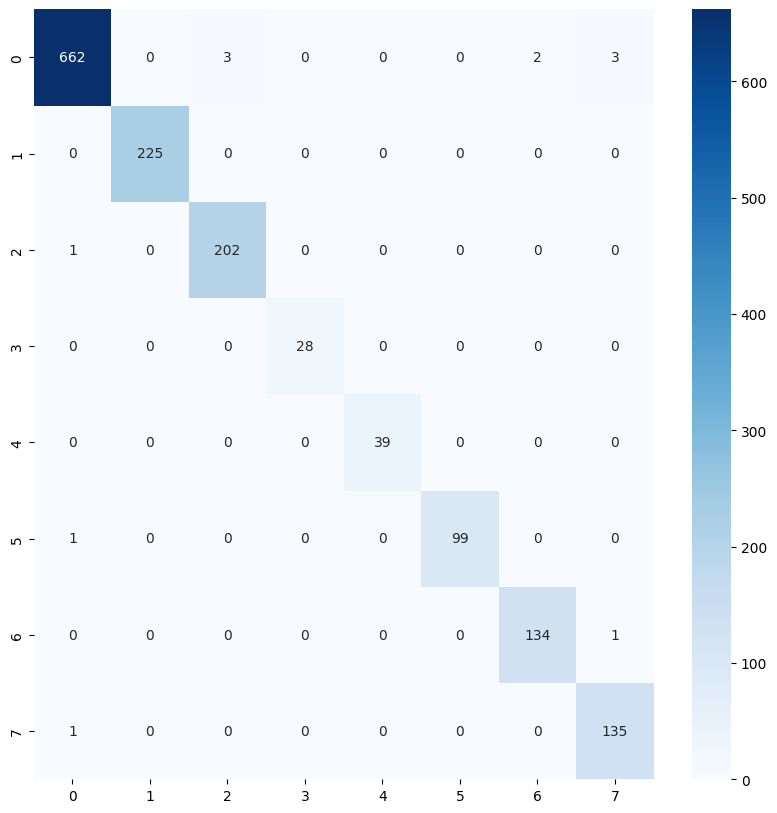

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(prepared_ds_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_labels
cm = confusion_matrix(y_true, y_pred)



In [ ]:
cm = ([[662,   2,   2,   0,   0,   0,   2,   2],
       [  2, 223,   0,   0,   0,   0,   0,   0],
       [  2,   0, 200,   0,   0,   1,   0,   0],
       [  0,   0,   0,  28,   0,   0,   0,   0],
       [  0,   0,   0,   0,  39,   0,   0,   0],
       [  0,   0,   0,   0,   0,  100,   0,   0],
       [  0,   0,   0,   0,   0,   0, 135,   0],
       [  2,   0,   0,   0,   0,   0,   0, 134]])

cm2 = ([[459,2,47,2,152]])

cm3 =  [
    [25, 2, 21, 32, 6, 1, 0, 48],
    [21, 12, 14, 17, 11, 0, 0, 25],
    [31, 12, 30, 42, 15, 3, 0, 70],
    [23, 5, 23, 26, 13, 2, 0, 44],
    [27, 3, 47, 47, 32, 5, 0, 64],
    [6, 1, 3, 9, 2, 3, 0, 15],
    [0, 0, 4, 8, 2, 0, 0, 8],
    [137, 30, 103, 122, 55, 4, 1, 218]
]

cm3_reversed = [
    [218, 1, 4, 55, 122, 103, 30, 137],
    [8, 0, 0, 2, 8, 4, 0, 0],
    [15, 0, 3, 2, 9, 3, 1, 6],
    [64, 0, 5, 32, 47, 47, 3, 27],
    [44, 0, 2, 13, 26, 23, 5, 23],
    [70, 0, 3, 15, 42, 30, 12, 31],
    [25, 0, 0, 11, 17, 14, 12, 21],
    [48, 0, 1, 6, 32, 21, 2, 25]
]


cm4 = ([[669,   0,   0,   0,   1,   0,   0,   0],
       [  0, 225,   0,   0,   0,   0,   0,   0],
       [  1,   0, 202,   0,   0,   0,   0,   0],
       [  0,   0,   0,  28,   0,   0,   0,   0],
       [  0,   0,   0,   0,  39,   0,   0,   0],
       [  0,   0,   0,   0,   0,  100,   0,   0],
       [  0,   0,   0,   0,   0,   0, 135,   0],
       [  0,   0,   0,   0,   0,   0,   0, 136]])



Text(58.222222222222214, 0.5, 'True labels')

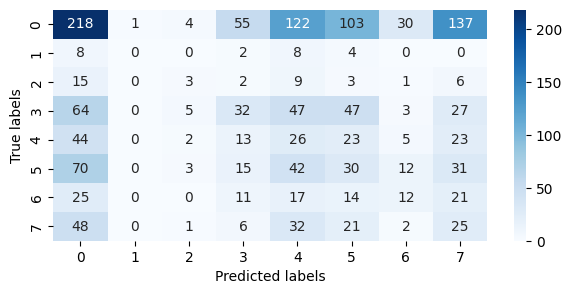

In [ ]:
plt.figure(figsize=(7, 3))
sns.heatmap(cm3_reversed, annot=True, fmt='g', cmap='Blues')
#x-axis labels

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

## Extra Test

In [ ]:
# load us audio
extra = pq.read_table(source= 'extra.parquet').to_pandas()

In [ ]:
extra_audio = []
for r in extra['audio']:
    extra_audio.append(r['array'])

extra_melspectrograms = []
for audio in extra_audio:
    melspec = audio_to_melspectrogram(audio)
    extra_melspectrograms.append(melspec)

extra_resized_images = resize_images(extra_melspectrograms)
extra_normalized_images = abs(extra_resized_images / 255)
extra_final_images = []
for img in extra_normalized_images:
    final_image = np.stack((img,)*3, axis=-1)
    extra_final_images.append(final_image)
extra_final_images = np.array(extra_final_images)


In [ ]:
#output images to a folder
def save_images(images, path):
    for i in range(len(images)):
        image = images[i]
        image = Image.fromarray((image * 255).astype(np.uint8))
        image.save(f'{path}/image_{i}.png')

save_images(extra_final_images, 'extra_images')

In [ ]:
#save label
extra_labels = extra['accents']
#output the labels to a csv file
extra_labels.to_csv('extra_labels.csv', index=False)
#replace with numner
extra_labels = extra_labels.replace({'United States English': 0, 'India and South Asia (India, Pakistan, Sri Lanka)': 1, 'England English': 2, 'Scottish English': 3, 'Irish English': 4, 'Canadian English': 5, 'Australian English': 6, 'Filipino': 7})

In [ ]:
#load images randomly
from datasets import Dataset, Image
extra_images_path = []
for i in range(0, 698):
    extra_images_path.append(f'extra_images/image_{i}.png')

extra_dataset = Dataset.from_dict({"image": extra_images_path}).cast_column("image", Image())

In [ ]:
#first 1000 labels
extra_labels = extra_labels[:1000]

In [ ]:
extra_dataset = extra_dataset.add_column("labels", extra_labels)

In [ ]:
#predict
prepared_extra_ds = extra_dataset.with_transform(transform)
predictions = trainer.predict(prepared_extra_ds)

In [ ]:
predictions = np.argmax(predictions.predictions, axis=1)


In [ ]:
predictions

In [ ]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(extra_labels, predictions)

0.7091690544412608

In [ ]:
#count unique in predictions
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{0: 495, 2: 2, 3: 47, 5: 2, 7: 152}

([<matplotlib.axis.XTick at 0x7f92fe0cce50>,
 [Text(0, 0, 'United States English'),
  Text(1, 0, 'England English'),
  Text(2, 0, 'Scottish English'),
  Text(3, 0, 'Canadian English'),
  Text(4, 0, 'Filipino')])

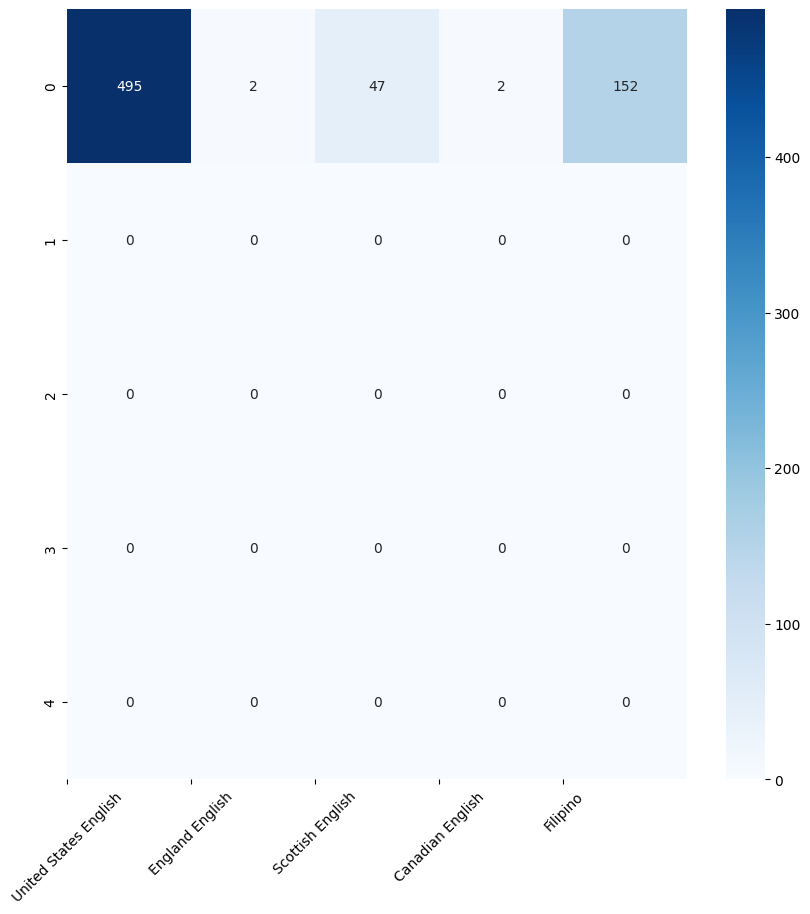

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(extra_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
#change x labels
plt.xticks(np.arange(5), ['United States English', 'England English', 'Scottish English', 'Canadian English', 'Filipino'], rotation=45)

## Extra 2

In [ ]:
extra2 = pq.read_table(source= 'extra2.parquet').to_pandas()

In [ ]:
extra_audio = []
for r in extra2['audio']:
    extra_audio.append(r['array'])

extra_melspectrograms = []
for audio in extra_audio:
    melspec = audio_to_melspectrogram(audio)
    extra_melspectrograms.append(melspec)

extra_resized_images = resize_images(extra_melspectrograms)
extra_normalized_images = abs(extra_resized_images / 255)
extra_final_images = []
for img in extra_normalized_images:
    final_image = np.stack((img,)*3, axis=-1)
    extra_final_images.append(final_image)
extra_final_images = np.array(extra_final_images)


In [ ]:
#output images to a folder
from PIL import Image
def save_images(images, path):
    for i in range(len(images)):
        image = images[i]
        image = Image.fromarray((image * 255).astype(np.uint8))
        image.save(f'{path}/image_{i}.png')

save_images(extra_final_images, 'extra2_images')

In [ ]:
extra2_labels = extra2['accents']
#output the labels to a csv file
extra2_labels.to_csv('extra2_labels.csv', index=False)
#replace with numner
extra2_labels = extra2_labels.replace({'United States English': 0, 'India and South Asia (India, Pakistan, Sri Lanka)': 1, 'England English': 2, 'Scottish English': 3, 'Irish English': 4, 'Canadian English': 5, 'Australian English': 6, 'Filipino': 7})

In [ ]:
#load images randomly
from datasets import Dataset, Image
extra2_images_path = []
for i in range(0, 697):
    extra2_images_path.append(f'extra2_images/image_{i}.png')

extra2_dataset = Dataset.from_dict({"image": extra2_images_path}).cast_column("image", Image())
extra2_dataset = extra2_dataset.add_column("labels", extra2_labels)

In [ ]:
#predict
prepared_extra2_ds = extra2_dataset.with_transform(transform)
predictions = trainer.predict(prepared_extra2_ds)

In [ ]:
#accuracy
predictions = np.argmax(predictions.predictions, axis=1)
accuracy_score(extra2_labels, predictions)


0.975609756097561

# Text Classification (Speech Transcript)

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
import torch.optim as optim
import time
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from PIL import Image
import librosa
from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight





cuda = torch.cuda.is_available()

## **Import the data**

Data Source: https://huggingface.co/datasets/WillHeld/accented_common_voice/tree/refs%2Fconvert%2Fparquet/default/partial-train

Text Transformer 1, PERT: https://huggingface.co/google-bert/bert-base-uncased


Due to the size and format of the original data file parquet, we decided to download the data and import it from our own laptop. The file link can be found above.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyarrow.parquet as pq

df0 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0000.parquet').to_pandas()
df1 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0001.parquet').to_pandas()
df2 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0002.parquet').to_pandas()
df3 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0003.parquet').to_pandas()
df4 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0004.parquet').to_pandas()
df5 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0005.parquet').to_pandas()
df6 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0006.parquet').to_pandas()
df7 = pq.read_table(source= '/content/drive/MyDrive/year3/ST311/0007.parquet').to_pandas()

In [ ]:
data = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7])
data.reset_index(drop=True, inplace=True)

In [ ]:
data

,path,accents,sentence,up_votes,down_votes,age,gender,audio
0,common_voice_en_23608720.mp3,"India and South Asia (India, Pakistan, Sri Lanka)",The liner notes were written by Mark Paytress ...,2.0,1.0,twenties,female,"{'array': [-1.7462298274040222e-10, -4.2200554..."
1,common_voice_en_23608721.mp3,"India and South Asia (India, Pakistan, Sri Lanka)",Microsoft has not made public statements about...,2.0,0.0,twenties,female,"{'array': [5.093170329928398e-11, 7.3669070843..."
2,common_voice_en_23608722.mp3,"India and South Asia (India, Pakistan, Sri Lanka)",It indicates a letter that must be typed and m...,2.0,0.0,twenties,female,"{'array': [0.0, -2.9103830456733704e-11, 4.365..."
3,common_voice_en_23608754.mp3,"India and South Asia (India, Pakistan, Sri Lanka)",Nasseri was born in the Anglo-Persian Oil Comp...,2.0,0.0,twenties,female,"{'array': [5.4569682106375694e-11, -7.27595761..."
4,common_voice_en_23608756.mp3,"India and South Asia (India, Pakistan, Sri Lanka)",He was also an ordained minister and led vario...,2.0,1.0,twenties,female,"{'array': [-8.731149137020111e-11, 1.273292582..."
...,...,...,...,...,...,...,...,...
7673,common_voice_en_25122812.mp3,United States English,A Game Gear game by the same name was publishe...,2.0,0.0,,,"{'array': [-2.4556356947869062e-11, -7.2759576..."
7674,common_voice_en_25122824.mp3,United States English,He is the only President of Latvia to die in o...,2.0,0.0,,,"{'array': [-1.0913936421275139e-11, -2.1827872..."
7675,common_voice_en_25122825.mp3,United States English,Luther Rice College and Seminary is a private ...,2.0,0.0,,,"{'array': [9.094947017729282e-13, -9.094947017..."
7676,common_voice_en_25122826.mp3,United States English,Songs from these albums have also been feature...,2.0,1.0,,,"{'array': [-2.7284841053187847e-12, -3.6379788..."


In [ ]:
set(data['accents'])

{'Australian English',
 'Canadian English',
 'England English',
 'Filipino',
 'India and South Asia (India, Pakistan, Sri Lanka)',
 'Irish English',
 'Scottish English',
 'United States English'}

In [ ]:
data['audio'][0]

{'array': array([-1.74622983e-10, -4.22005542e-10, -2.03726813e-10, ...,
         4.54552310e-06,  1.05218151e-05,  1.69793075e-05]),
 'path': './accents/datasets/common_voice_16_1/en/clips/common_voice_en_23608720.mp3',
 'sampling_rate': 16000}

## **Data Pre-processing**
Dealing with the class imbalance issues as the proportion of certain accents is far fewer than others. We first drop the columns that are unrelated to this research.

In [ ]:
data = data.drop(['path'], axis=1)
data = data.drop(['up_votes'], axis=1)
data = data.drop(['down_votes'], axis=1)
data = data.drop(['age'], axis=1)
data = data.drop(['gender'], axis=1)
data['accents'].value_counts()

accents
United States English                                3247
India and South Asia (India, Pakistan, Sri Lanka)    1188
England English                                      1094
Australian English                                    663
Filipino                                              607
Canadian English                                      495
Irish English                                         265
Scottish English                                      119
Name: count, dtype: int64

Then split the data to train and test set in the proportion of 8:2.

In [ ]:
#train test split
train, test = train_test_split(data, test_size=0.2, random_state=42)

train['accents'].value_counts()

accents
United States English                                2577
India and South Asia (India, Pakistan, Sri Lanka)     963
England English                                       891
Australian English                                    528
Filipino                                              471
Canadian English                                      395
Irish English                                         226
Scottish English                                       91
Name: count, dtype: int64

Then we upsamle and downsample the minority and majority class.

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Down sampling three classes
US = train[train['accents'] == 'United States English']
US = US.sample(n=550)

India_south_asia = train[train['accents'] == 'India and South Asia (India, Pakistan, Sri Lanka)']
India_south_asia = India_south_asia.sample(n=550)

england = train[train['accents'] == 'England English']
england = england.sample(n=550)

# Upsample minority class
scottish = train[train['accents'] == 'Scottish English']
Irish = train[train['accents'] == 'Irish English']
scottish = resample(scottish,replace=True,n_samples= 270, random_state=42)
Irish = resample(Irish,replace=True,n_samples= 450, random_state=42)

# Combine all classes
the_rest = []
new = []
the_rest = pd.concat([train[train['accents'] == 'Australian English'],train[train['accents'] == "Filipino"], train[train['accents'] == 'Canadian English']])
new = pd.concat([US, India_south_asia,england,scottish,Irish,the_rest])

# Display new class counts
new.reset_index(drop=True, inplace=True)
new['accents'].value_counts()

accents
United States English                                550
India and South Asia (India, Pakistan, Sri Lanka)    550
England English                                      550
Australian English                                   528
Filipino                                             471
Irish English                                        450
Canadian English                                     395
Scottish English                                     270
Name: count, dtype: int64

In [ ]:
train_ds = Dataset.from_pandas(new)
test_ds = Dataset.from_pandas(test)

train_ds = train_ds.class_encode_column("accents")
test_ds = test_ds.class_encode_column("accents")

Casting to class labels:   0%|          | 0/3764 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1536 [00:00<?, ? examples/s]

Audio is not the interest of text classification, therefore remove the column.

In [ ]:
train_ds = train_ds.remove_columns("audio")
test_ds = test_ds.remove_columns("audio")

In [ ]:
labels = train_ds.features["accents"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
train_ds

Dataset({
    features: ['accents', 'sentence'],
    num_rows: 3764
})

##**Bert**

Tokenize the data

In [ ]:
# tokenize the data
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence"], padding = "max_length")

tokenized_datasets_train = train_ds.map(tokenize_function, batched=True)
tokenized_datasets_test = test_ds.map(tokenize_function, batched=True)

tokenized_datasets_train = tokenized_datasets_train.rename_column("accents","label")
tokenized_datasets_test = tokenized_datasets_test.rename_column("accents","label")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3764 [00:00<?, ? examples/s]

Map:   0%|          | 0/1536 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets_train

Dataset({
    features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3764
})

In [ ]:
pip install transformers[torch]

In [ ]:
pip install evaluate

##**8 epoch**

Define and train the BERT model with 8 epochs.

In [ ]:
#Define a training arguments class
from transformers import TrainingArguments
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", num_train_epochs=8)


#Define the model
num_labels = len(id2label)
num_labels
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=num_labels)


#Define the compute metrics
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


#Define a trainer
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.984597,0.160807
2,2.062500,1.947822,0.218099
3,1.762400,2.161429,0.187500
4,1.226100,2.723784,0.177083
5,0.585400,4.005829,0.184896
6,0.166800,4.573924,0.234375
7,0.049300,5.164403,0.202474
8,0.006100,5.232408,0.208984


TrainOutput(global_step=3768, training_loss=0.7775677567043375, metrics={'train_runtime': 875.9845, 'train_samples_per_second': 34.375, 'train_steps_per_second': 4.301, 'total_flos': 7923226912751616.0, 'train_loss': 0.7775677567043375, 'epoch': 8.0})

The plot on the changes of trainingh loss, validation loss and accuracy

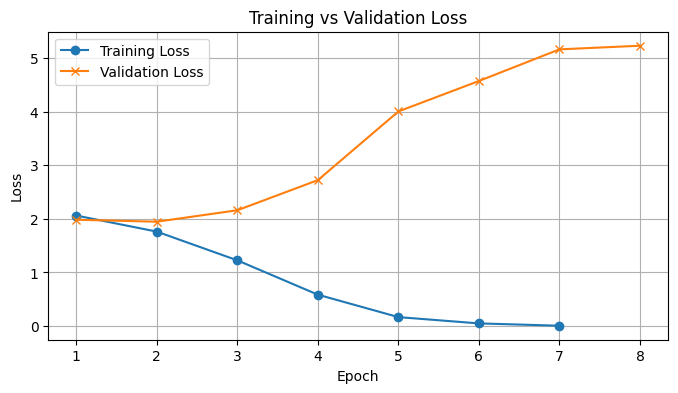

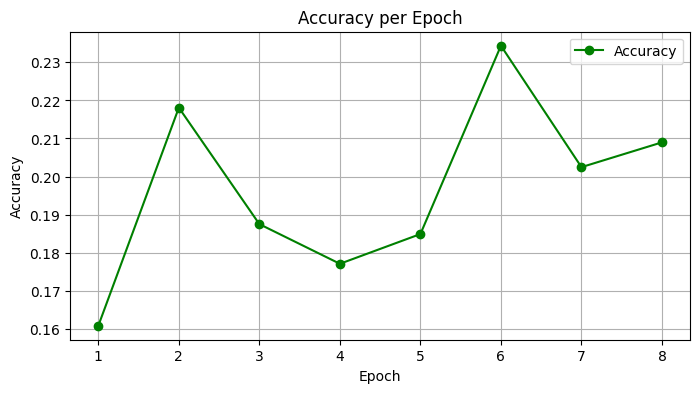

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

epochs = []
training_loss = [None] * len(epochs)  # Initialize with None
validation_loss = [None] * len(epochs)  # Initialize with None
accuracy = []

# Extracting data from log_history
for log in log_history:
    if 'epoch' in log:
        epoch_index = int(log['epoch']) - 1  # Convert to 0-indexed
        while len(epochs) <= epoch_index:  # Append to epochs list if this epoch is not yet included
            epochs.append(len(epochs) + 1)
            training_loss.append(None)  # Append None for this new epoch
            validation_loss.append(None)  # Append None for this new epoch
        # Now we safely assume that the lengths of the lists are equal to epoch_index + 1
        if 'loss' in log:
            training_loss[epoch_index] = log['loss']
        if 'eval_loss' in log:
            validation_loss[epoch_index] = log['eval_loss']
        if 'eval_accuracy' in log:
            accuracy.append(log['eval_accuracy'])

# Filter out the epochs where we have validation loss to match with training loss
valid_epochs = [epoch for epoch, val_loss in zip(epochs, validation_loss) if val_loss is not None]
valid_validation_loss = [val_loss for val_loss in validation_loss if val_loss is not None]

# Comparison plot of training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(valid_epochs, valid_validation_loss, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Ensure the list lengths match for accuracy plot
while len(accuracy) < len(epochs):
    accuracy.append(None)

# Separate plot for accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix on the BERT Transformer

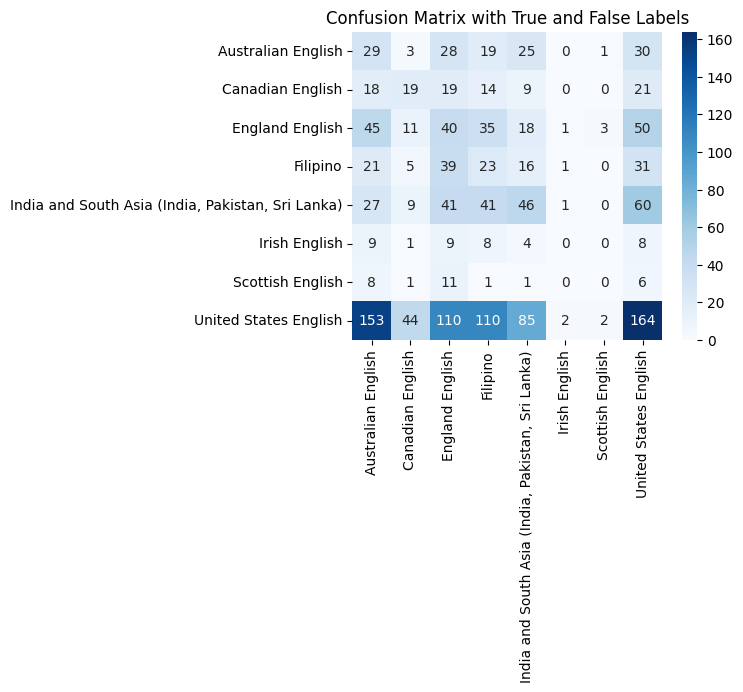

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(tokenized_datasets_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = tokenized_datasets_test['label']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with True and False Labels')
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())


##**5 epoch**

Define and train the model with 5 epochs.

In [ ]:
#Define a training arguments class
from transformers import TrainingArguments
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", num_train_epochs=5)


#Define the model
num_labels = len(id2label)
num_labels
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=num_labels)


#Define the compute metrics
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


#Define a trainer
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.004365,0.134766
2,2.071700,1.953544,0.162109
3,1.789400,2.034272,0.203776
4,1.268700,2.581603,0.171224
5,0.686900,2.747876,0.225260


TrainOutput(global_step=2355, training_loss=1.2882614556897725, metrics={'train_runtime': 548.8262, 'train_samples_per_second': 34.291, 'train_steps_per_second': 4.291, 'total_flos': 4952016820469760.0, 'train_loss': 1.2882614556897725, 'epoch': 5.0})

Do the plotting as above.

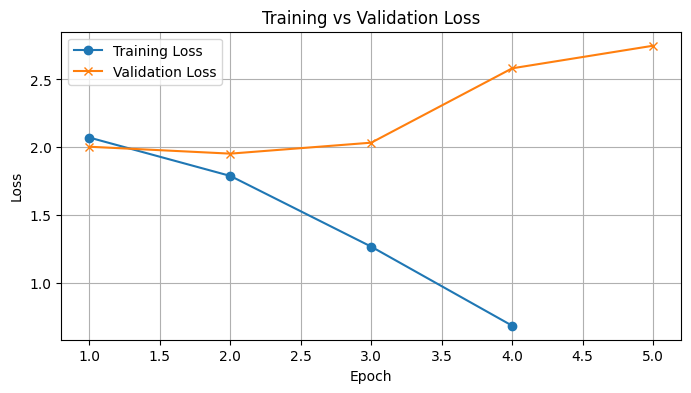

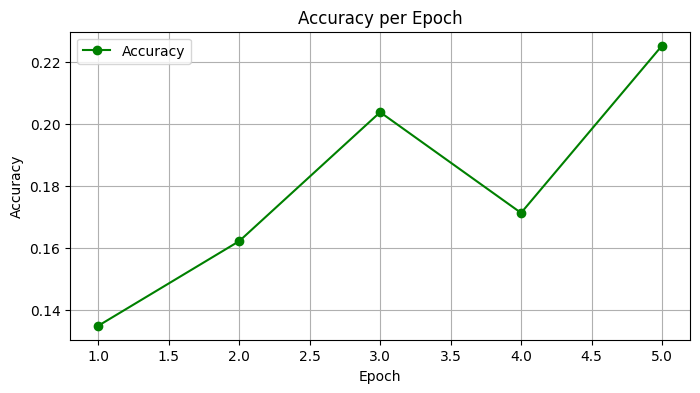

In [ ]:
import matplotlib.pyplot as plt

# Assuming trainer.state.log_history contains the logged metrics
log_history = trainer.state.log_history

epochs = []
training_loss = [None] * len(epochs)  # Initialize with None
validation_loss = [None] * len(epochs)  # Initialize with None
accuracy = []

# Extracting data from log_history
for log in log_history:
    if 'epoch' in log:
        epoch_index = int(log['epoch']) - 1  # Convert to 0-indexed
        while len(epochs) <= epoch_index:  # Append to epochs list if this epoch is not yet included
            epochs.append(len(epochs) + 1)
            training_loss.append(None)  # Append None for this new epoch
            validation_loss.append(None)  # Append None for this new epoch
        # Now we safely assume that the lengths of the lists are equal to epoch_index + 1
        if 'loss' in log:
            training_loss[epoch_index] = log['loss']
        if 'eval_loss' in log:
            validation_loss[epoch_index] = log['eval_loss']
        if 'eval_accuracy' in log:
            accuracy.append(log['eval_accuracy'])

# Filter out the epochs where we have validation loss to match with training loss
valid_epochs = [epoch for epoch, val_loss in zip(epochs, validation_loss) if val_loss is not None]
valid_validation_loss = [val_loss for val_loss in validation_loss if val_loss is not None]

# Comparison plot of training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(valid_epochs, valid_validation_loss, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Ensure the list lengths match for accuracy plot
while len(accuracy) < len(epochs):
    accuracy.append(None)

# Separate plot for accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

And this is the confusion matrix.

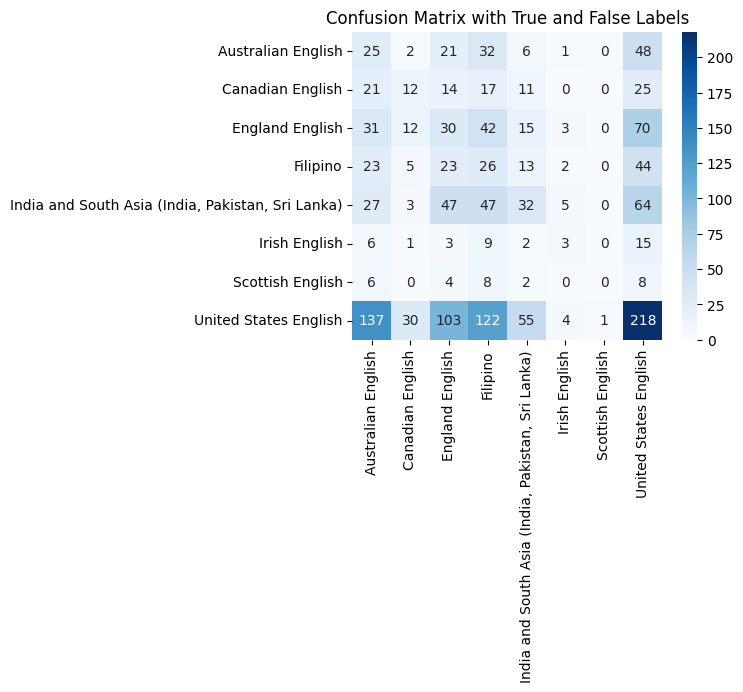

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(tokenized_datasets_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = tokenized_datasets_test['label']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with True and False Labels')
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())